In [1]:
import torch
from matplotlib import pyplot as plt
import torch.optim as optim

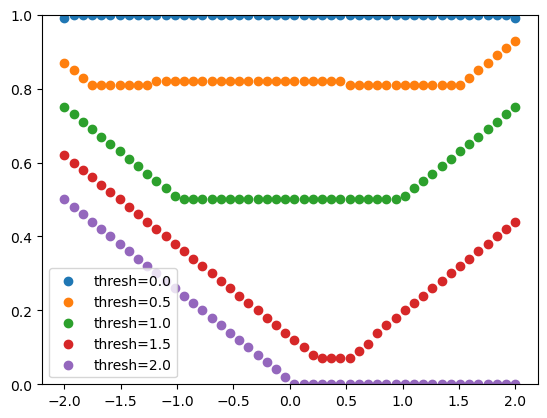

In [45]:
# Define Noisy Objective Function
def expensive_function(x):
    """The 1st column of x gives the nominal inputs, 2nd column gives the input noise"""
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    # Add some additional noise we want to capture via Bayesian layers
    std = 0.1
    mu = torch.zeros(x.shape[0])
    extra_noise = torch.normal(mean=mu, std=std)
    return noised_value #+ extra_noise

# Define computation of 'true' robustness measure by brute force sampling
def robust_measures(x_design, robustness_thresh, eps=2, num_eps_samples=100, num_repeats=100):
    robust_measures = torch.empty((x_design.shape[0], 1))
    for i, x_d in enumerate(x_design):
        x = torch.empty((num_eps_samples, 2))
        x[:,0] = x_d.repeat(num_eps_samples)
        x[:,1] = torch.linspace(-eps, eps, num_eps_samples)
        x = x.repeat((num_repeats,1))
        robust_measure = torch.sum(expensive_function(x) > robustness_thresh) / len(x)
        robust_measures[i] = robust_measure
    return robust_measures

EPS = 2
x_design = torch.linspace(-EPS, EPS, 50)

# Check out robustness measure at different thresholds
for robustness_thresh in torch.linspace(0,2,5):
    true_robust_measures = robust_measures(x_design, robustness_thresh=robustness_thresh, 
                                           eps=EPS, num_eps_samples=100, num_repeats=100)
    
    plt.scatter(x_design, true_robust_measures, label=f'thresh={torch.round(robustness_thresh, decimals=2)}')
    plt.ylim(0, 1);
    plt.legend()

# Use threshold with a clear minimum for testing
ROBUSTNESS_THRESH = 1.5
true_robust_measures = robust_measures(x_design, robustness_thresh=ROBUSTNESS_THRESH, 
                                       eps=EPS, num_eps_samples=500, num_repeats=500)

# Generate training data for NN
NUM_TRAIN = 65
NUM_TRAIN_REPEATS = 1
train_x = torch.empty(NUM_TRAIN, 2)
train_x[:,0].uniform_(-2,2)
train_x[:,1].uniform_(-EPS, EPS)
train_x = train_x.repeat((NUM_TRAIN_REPEATS,1)) # Generate repeats of the initial points to help learn variance
train_y  = expensive_function(train_x)

In [50]:
models = {}
num_models = 2
for model_i in range(num_models):
    if model_i == 0:
        from NN_deterministic import *
        # SAMPLE_NBR = 6
        models.update({str(model_i): {}})
        models[str(model_i)]['label'] = 'deterministic NN'
    elif model_i == 1:
        from NN_bayesian import *
        # SAMPLE_NBR = 9
        models.update({str(model_i): {}})
        models[str(model_i)]['label'] = 'bayesian NN'
    SAMPLE_NBR = 6
    NUM_EPOCHS = 2000
    HIDDEN_DIM = 50

    model = NN(input_dim=train_x.shape[1], hidden_dim = HIDDEN_DIM)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f'training model {model_i}')
    for epoch in range(NUM_EPOCHS):
        optimizer.zero_grad()
        loss = loss_fn(model, train_x, train_y, sample_nbr=SAMPLE_NBR, complexity_cost_weight=1e-6)
        loss.backward()
        optimizer.step()
        if epoch % (int(NUM_EPOCHS/10)) == 0:
            print(f"Epoch {epoch}: ELBO Loss = {loss.item():.4f}")
    models[str(model_i)]['trained_model'] = model

training model 0
Epoch 0: ELBO Loss = 135.3735
Epoch 200: ELBO Loss = 1.9467
Epoch 400: ELBO Loss = 0.1879
Epoch 600: ELBO Loss = -0.1752
Epoch 800: ELBO Loss = -0.3733
Epoch 1000: ELBO Loss = -0.5242
Epoch 1200: ELBO Loss = -0.6586
Epoch 1400: ELBO Loss = -0.7994
Epoch 1600: ELBO Loss = -0.9613
Epoch 1800: ELBO Loss = -1.1541
training model 1
Epoch 0: ELBO Loss = 1.5857
Epoch 200: ELBO Loss = 0.0702
Epoch 400: ELBO Loss = 0.0237
Epoch 600: ELBO Loss = 0.0137
Epoch 800: ELBO Loss = 0.0084
Epoch 1000: ELBO Loss = 0.0037
Epoch 1200: ELBO Loss = 0.0026
Epoch 1400: ELBO Loss = 0.0021
Epoch 1600: ELBO Loss = 0.0021
Epoch 1800: ELBO Loss = 0.0019


Text(0, 0.5, 'MSE on robust measure')

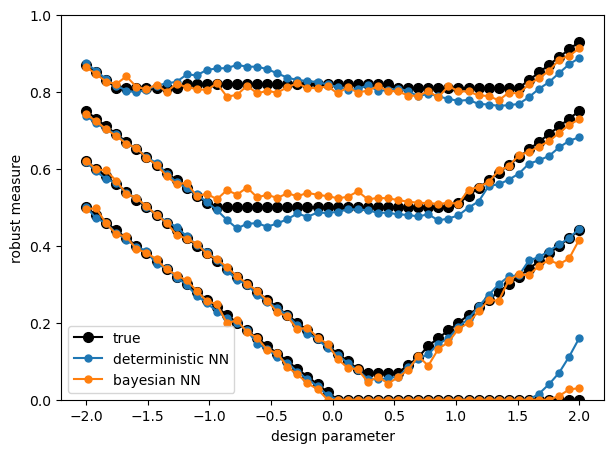

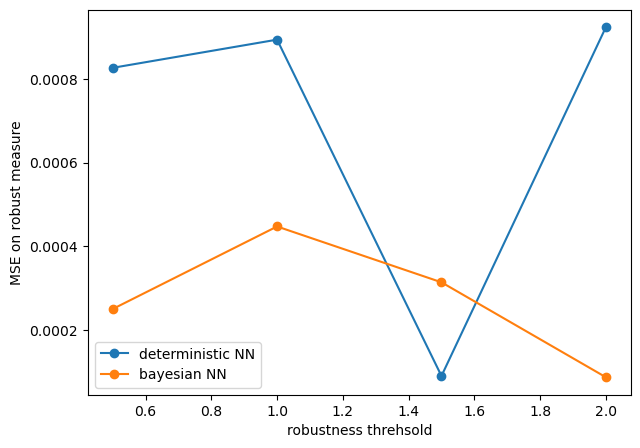

In [51]:
# Initialize a place to store MSE results
for model_i in range(num_models):
    models[str(model_i)]['all_mse'] = []

robustness_thresholds = torch.linspace(0.5,2,4)
fig, ax = plt.subplots(1, figsize=(7,5))
ax.set_ylim(0,1)
ax.set_ylabel('robust measure')
ax.set_xlabel('design parameter')
for thresh_i, robustness_thresh in enumerate(robustness_thresholds):
    true_robust_measures = robust_measures(x_design, robustness_thresh=robustness_thresh, 
                                           eps=EPS, num_eps_samples=100, num_repeats=100)
    ax.plot(x_design, true_robust_measures, marker='o', c='k', markersize=7, label=('true' if thresh_i==0 else '_'))

    for model_i in range(num_models):
        model = models[str(model_i)]['trained_model']
        model_label = models[str(model_i)]['label'] if thresh_i==0 else '_'
        model_robust_measures = model.posterior_robust(x_design, robustness_thresh, num_eps_samples=10000, eps=EPS)
        mse = torch.square(torch.abs(model_robust_measures - true_robust_measures)).mean()
        models[str(model_i)]['all_mse'].append(mse)

        ax.plot(x_design, model_robust_measures, marker='o', markersize=5, 
                 label=f"{model_label}", color=f'C{model_i}')
        ax.legend()

fig, ax = plt.subplots(1, figsize=(7,5))
for model_i in range(num_models):
    ax.plot(robustness_thresholds, models[str(model_i)]['all_mse'], label=models[str(model_i)]['label'], marker='o')
ax.legend()
ax.set_xlabel('robustness threhsold')
ax.set_ylabel('MSE on robust measure')

Bayesian MSE seems more consistent wrt to retraining (on same training data) than Deterministic. Sometimes Deterministic spikes. 